In [1]:
import sim
import util
import synthetics
import numpy as np
import utilities
from IPython.display import clear_output
from models import GibbsSLDA, GibbsLDA

clear_output()

In [2]:
def generate_datasets(n_sections, n_genes, n_informative, n_cells=900, n_topics=2, blocks=None, mode=None, mixed=False, means=None, variances=None, x_max=30, y_max=30):
    args = tuple(locals().values())[1:]

    if means is None:
        means, variances = synthetics.generate_means(n_genes, n_informative, max(n_topics))
    sections, labels = [], []

    for i in range(len(mode)):
        # idx = np.random.permutation(max(n_topics))[:n_topics[i]]
        idx = np.random.choice(max(n_topics), n_topics[i])
        m = means[idx]
        dataset, label = synthetics.generate_dataset(n_genes, n_informative, n_cells[i], n_topics[i], blocks[i], mode[i], mixed, m, variances, x_max, y_max)
        dataset = np.concatenate([np.ones((dataset.shape[0], 1))*i, dataset], -1)
        sections.append(dataset)
        for j in range(len(label)):
            label[j] = idx[label[j]]
        labels.append(label)

    datasets = np.stack(sections)
    labels = np.stack(labels)

    return datasets, labels

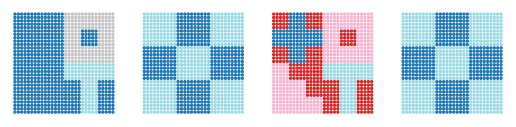

In [81]:
N_GENES = 1000
N_INFORMATIVE = 1000
N_CELLS = [1, 1, 1, 1]
N_TOPICS = [5, 2, 5, 2]
MODE = ['block', 'block', 'block', 'block']
BLOCKS = [synthetics.GGBLOCKS, synthetics.CHBLOCKS, synthetics.GGBLOCKS, synthetics.CHBLOCKS]
MIXED = False

datasets, labels = generate_datasets(3, N_GENES, N_INFORMATIVE, N_CELLS, N_TOPICS, BLOCKS, MODE, MIXED)
N_IMGS, N_SAMPLES, N_FEATURES = datasets.shape
X = np.zeros((N_IMGS*N_SAMPLES, N_FEATURES))
X_labels = np.zeros(N_IMGS*N_SAMPLES, dtype=np.int32)
# X_idx = np.ones((N_IMGS*N_SAMPLES, 1))
for i in range(N_IMGS):
    j, k = i*N_SAMPLES, (i + 1)*N_SAMPLES
    X[j:k], X_labels[j:k] = datasets[i], labels[i]
    # X_idx[j:k] = i + 1
# X = np.concatenate([X_idx, X], -1)
utilities.visualize_datasets(datasets, X_labels.reshape(N_IMGS, N_SAMPLES), size=2, show_ax=False)

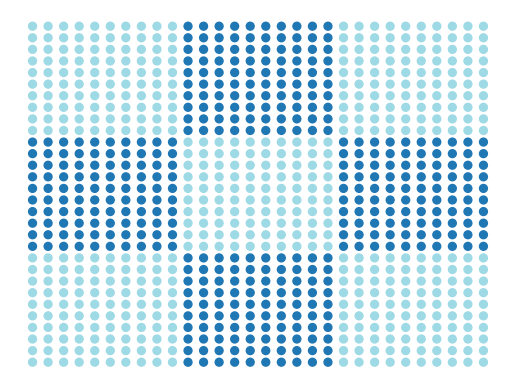

In [115]:
IMG = 4

utilities.visualize_datasets(datasets[IMG - 1], X_labels[(IMG - 1)*N_SAMPLES:IMG*N_SAMPLES].reshape(1, N_SAMPLES), size=32, show_ax=False)

In [116]:
Z_labels = np.copy(X_labels[(IMG - 1)*N_SAMPLES:IMG*N_SAMPLES])
# Z_labels[Z_labels == 3] = 0
# Z_labels[Z_labels == 4] = 1

100%|██████████| 200/200 [00:07<00:00, 28.27it/s]

Score: 0.9844444444444445


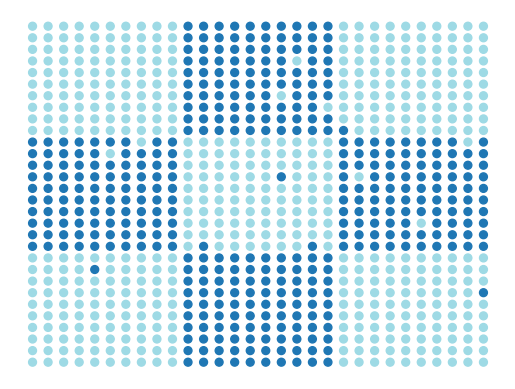

In [117]:
N_STEPS = 200
N_DOCS = 150
VOCAB_SIZE = 15
SIGMA = .01

model = GibbsSLDA(2, N_DOCS, VOCAB_SIZE, sigma=SIGMA)
labels = model.fit_transform(X[(IMG - 1)*N_SAMPLES:IMG*N_SAMPLES], N_STEPS)
Y_labels, score = util.evaluate(Z_labels, labels)
print('Score:', score)
utilities.visualize_datasets(datasets[IMG - 1], Y_labels.reshape(1, N_SAMPLES), size=32, show_ax=False)

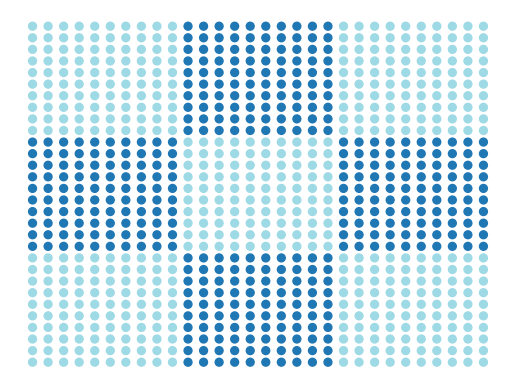

In [89]:
utilities.visualize_datasets(datasets[3], Y_labels.reshape(N_IMGS, N_SAMPLES)[3], size=32, show_ax=False)

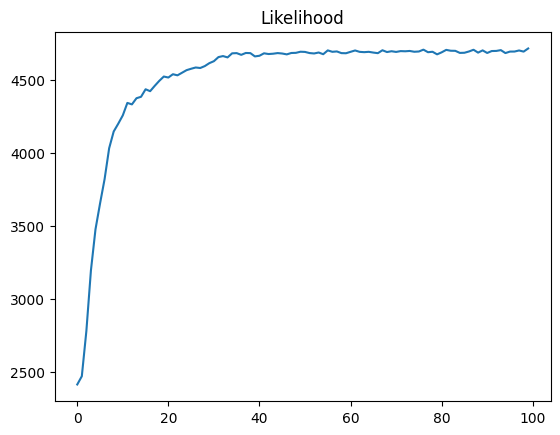

In [84]:
util.visualize_log(model.likelihood_log_, 'Likelihood')

In [ ]:
from scipy.spatial.distance import cdist

imgs = model.library_[:, :1]
locs = model.library_[:, 1:3]
words = model.library_[:, 3:4].astype(np.int32)
docs = model.library_[:, 4:5].astype(np.int32)
topics = model.library_[:, 5:].astype(np.int32)
mask = (cdist(model.doc_imgs_, imgs) == 0).astype(np.int32)
doc_probs = mask*model.sigma**2/(cdist(model.doc_locs_, locs) + 1e-100)
topic_probs = (model.doc_topic_counts_[:, topics] + model.alpha).reshape(model.n_docs, model.library_.shape[0])
topic_probs /= (model.doc_topic_counts_ + model.alpha).sum(-1)[:, None]
probs = doc_probs*topic_probs
probs /= probs.sum(0)[None]
model.library_[:, 4] = np.argmax(np.log(probs + 1e-100) + np.random.gumbel(size=probs.shape), 0)

topic_probs = (model.doc_topic_counts_[docs] + model.alpha).reshape(3600, 5)
topic_probs /= (model.doc_topic_counts_[docs] + model.alpha).sum(-1)
word_probs = (model.topic_word_counts_[:, words] + model.beta).reshape(3600, 5)
word_probs /= word_probs.sum(-1)[:, None]
probs = topic_probs*word_probs
probs /= probs.sum(0)[None]
model.library_[:, -1] = np.argmax(np.log(probs + 1e-100) + np.random.gumbel(size=probs.shape), 1)

docs = model.library_[:, 4]
topics = model.library_[:, -1]
for d in range(model.n_docs):
    idx, counts = np.unique(topics[docs == d], return_counts=True)
    model.doc_topic_counts_[d, idx.astype(np.int32)] = counts
for k in range(model.n_topics):
    idx, counts = np.unique(words[topics == k], return_counts=True)
    model.topic_word_counts_[k, idx.astype(np.int32)] = counts

## Spine Data

In [177]:
import muon as mu
import numpy as np
from sklearn.neighbors import NearestNeighbors

def remove_lonely(data, labels, threshold=225., n_neighbors=12):
    locs = data[:, :2]
    knn = NearestNeighbors(n_neighbors=n_neighbors).fit(locs)
    max_dist = knn.kneighbors()[0].max(-1)
    remove_idx, = np.where(max_dist > threshold)
    data = np.delete(data, remove_idx, axis=0)
    labels = np.delete(labels, remove_idx, axis=0)
    return data, labels

def read_spine_data(filename, threshold=225., n_neighbors=12, feature_key='protein', id_key='protein:celltype'):
    mdata = mu.read(filename)
    x, y = mdata['physical'].obsm['spatial'].T
    features = mdata[feature_key].X
    data = np.concatenate([x[None].T, y[None].T, features], -1)
    ids = mdata.obs[id_key]
    labels = np.unique(ids, return_inverse=True)[1]
    if threshold is not None:
        data, labels = remove_lonely(data, labels, threshold, n_neighbors)
    return data, labels

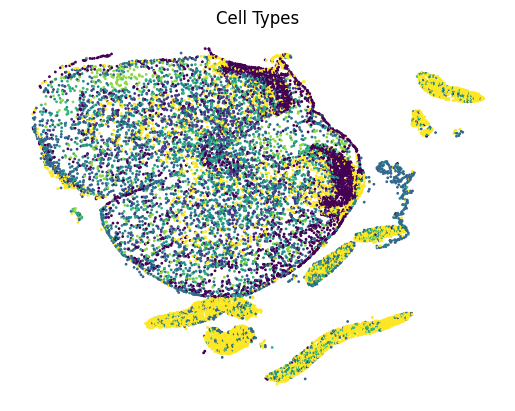

In [178]:
X, X_labels = read_spine_data('data/m387ntga2.h5mu')
clear_output()
util.visualize_data(X, X_labels, 'Cell Types', size=1, show_ax=False)

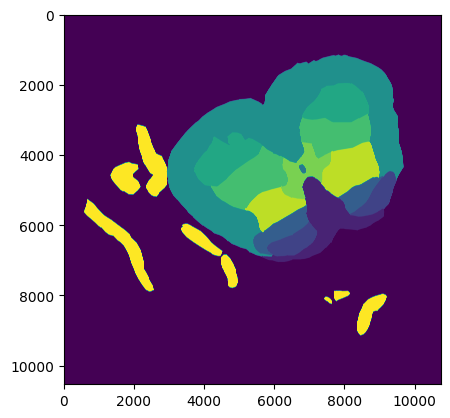

In [179]:
from skimage import io
import matplotlib.pyplot as plt

img = io.imread('data/m387ntga2.tiff').astype(np.int32)
plt.imshow(img);

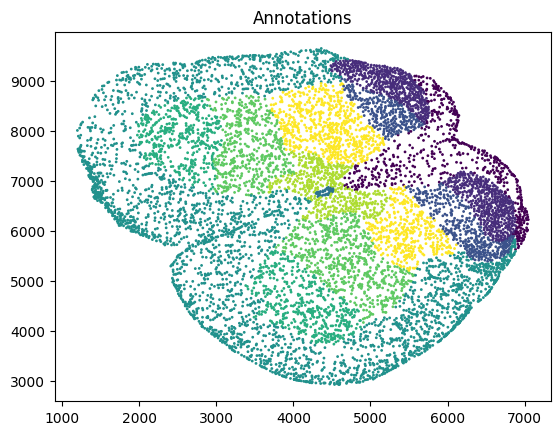

In [180]:
from scipy import ndimage
from skimage.segmentation import watershed

distance = ndimage.distance_transform_edt(img)
labels = watershed(-distance, 2, mask=img)
X_labels = np.zeros_like(X_labels)
for i in range(X_labels.shape[0]):
    x, y = int(X[i, 0]), int(X[i, 1])
    val = labels[x, y]
    if val > 0:
        X_labels[i] = img[x, y]
X = np.delete(X, np.where(X_labels == 0), 0)
X_labels = np.delete(X_labels, np.where(X_labels == 0), 0)
util.visualize_data(X, X_labels, 'Annotations', size=1)

In [409]:
N_IMGS = 3
Z = np.stack([X for _ in range(N_IMGS)])
Z_labels = np.stack([X_labels for _ in range(N_IMGS)]).reshape(N_IMGS*X.shape[0])

# Z[1][:, 0] = -Z[0][:, 0]
# Z[1][:, 1] = Z[0][:, 1]

# cut_size = 2000
# Z1 = X[X[:, 0].argsort()[cut_size:]]
# Z1_labels = X_labels[X[:, 0].argsort()[cut_size:]]
# Z2 = X[X[:, 0].argsort()[:-cut_size]]
# Z2_labels = X_labels[X[:, 0].argsort()[:-cut_size]]
# Z3 = X[X[:, 1].argsort()[cut_size:]]
# Z3_labels = X_labels[X[:, 1].argsort()[cut_size:]]
# Z = np.stack([Z1, Z2, Z3])
# Z_labels = np.stack([Z1_labels, Z2_labels, Z3_labels])

# dmg_size = 4000
# Z1_idx = np.random.permutation(X.shape[0])[:X.shape[0] - dmg_size]
# Z1 = X[Z1_idx]
# Z1_labels = X_labels[Z1_idx]
# Z2_idx = np.random.permutation(X.shape[0])[:X.shape[0] - dmg_size]
# Z2 = X[Z2_idx]
# Z2_labels = X_labels[Z2_idx]
# Z3_idx = np.random.permutation(X.shape[0])[:X.shape[0] - dmg_size]
# Z3 = X[Z3_idx]
# Z3_labels = X_labels[Z3_idx]
# Z = np.stack([Z1, Z2, Z3])
# Z_labels = np.stack([Z1_labels, Z2_labels, Z3_labels])

partial_size = 500
Z1_idx = np.where(X_labels == 2)[0]
Z1_idx = Z1_idx[:Z1_idx.shape[0] - partial_size]
Z1_idx = np.concatenate([np.where(X_labels != 2)[0], Z1_idx])
Z1 = X[Z1_idx]
Z1_labels = X_labels[Z1_idx]
Z2_idx = np.where(X_labels == 3)[0]
Z2_idx = Z1_idx[:Z2_idx.shape[0] - partial_size]
Z2_idx = np.concatenate([np.where(X_labels != 3)[0], Z2_idx])
Z2 = X[Z2_idx]
Z2_labels = X_labels[Z2_idx]
Z3_idx = np.where(X_labels == 6)[0]
Z3_idx = Z1_idx[:Z3_idx.shape[0] - partial_size]
Z3_idx = np.concatenate([np.where(X_labels != 6)[0], Z3_idx])
Z3 = X[Z3_idx]
Z3_labels = X_labels[Z3_idx]
Z = np.stack([Z1, Z2, Z3])
Z_labels = np.stack([Z1_labels, Z2_labels, Z3_labels])

Z.shape

(3, 8315, 15)

In [410]:
idx = np.zeros((N_IMGS*Z.shape[1], 1))
for i in range(1, N_IMGS):
    idx[i*X.shape[0]:(i + 1)*X.shape[0]] = i
Z = np.concatenate([idx, Z.reshape(N_IMGS*Z.shape[1], X.shape[1])], -1)
Z.shape

(24945, 16)

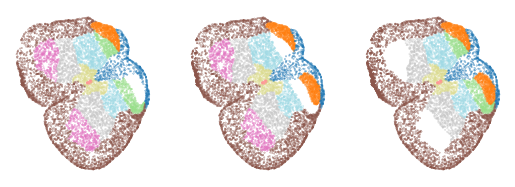

In [411]:
utilities.visualize_datasets(Z.reshape(N_IMGS, Z.shape[0]//N_IMGS, X.shape[1] + 1), Z_labels.reshape(N_IMGS, Z.shape[0]//N_IMGS), size=.05, show_ax=False)

In [412]:
Z_labels = Z_labels.reshape(Z_labels.shape[0]*Z_labels.shape[1])

100%|██████████| 300/300 [07:06<00:00,  1.42s/it]


Score: 0.4036079374624173


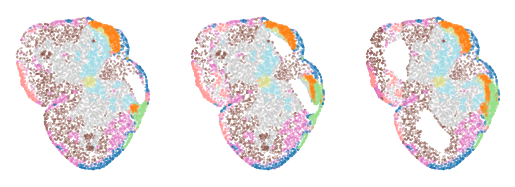

In [413]:
N_TOPICS = 9
N_DOCS = 150
VOCAB_SIZE = 25
SIGMA = 150.
N_STEPS = 300

model = GibbsSLDA(N_TOPICS, N_DOCS, VOCAB_SIZE, sigma=SIGMA)
labels = model.fit_transform(Z, N_STEPS)
Y_labels, score = util.evaluate(Z_labels, labels)
print('Score:', score)
# util.visualize_data(X[:, 1:3], Y_labels, 'Predicted Labels', size=1)
# util.visualize_log(model.likelihood_log_, 'Likelihood')
utilities.visualize_datasets(Z.reshape(N_IMGS, Z.shape[0]//N_IMGS, X.shape[1] + 1), Y_labels.reshape(N_IMGS, Z.shape[0]//N_IMGS), size=.05, show_ax=False)

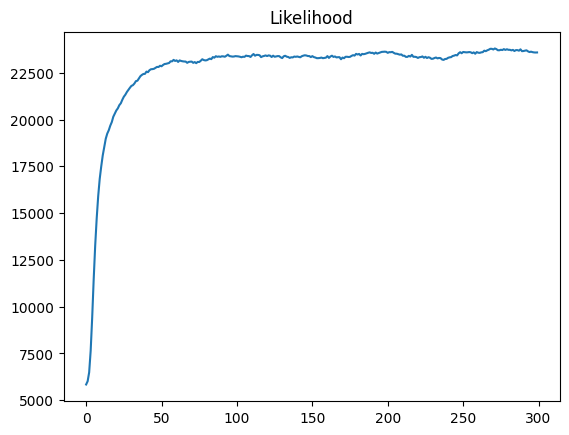

In [317]:
util.visualize_log(model.likelihood_log_, 'Likelihood')